In [1]:
import pandas as pd
import numpy as np

# Load pieman_segments
pieman_segments = pd.read_csv("pieman_segments.csv")

# Compute row-wise mode of LLM segment indices
segment_cols = [f"segment_idx_{i}" for i in range(6)]
pieman_segments["mode_segment"] = pieman_segments[segment_cols].apply(lambda row: row.mode().iloc[0], axis=1)

# Keep only TR and mode_segment
clean_seg = pieman_segments[["TR", "mode_segment"]].copy()

# Get one row per TR (e.g., first token in TR)
clean_seg = clean_seg.groupby("TR").agg({"mode_segment": "first"}).reset_index()

# Compute segment boundary (no boundary on the first row)
clean_seg["segment_boundary"] = (clean_seg["mode_segment"] != clean_seg["mode_segment"].shift()).astype(int)
clean_seg.loc[0, "segment_boundary"] = 0  # make sure first row is 0

# Create full TR range
full_trs = pd.DataFrame({"TR": range(1, 301)})

# Merge with existing data
clean_seg_full = pd.merge(full_trs, clean_seg, on="TR", how="left")

# Fill missing segment_boundary with 0
clean_seg_full["segment_boundary"] = clean_seg_full["segment_boundary"].fillna(0).astype(int)

# Have ready to feed into cross correlation
event_boundaries = list(clean_seg_full["segment_boundary"])

# Start with segment_boundary as a float list to allow NaNs
event_boundaries = clean_seg_full["segment_boundary"].astype(float).tolist()

event_boundaries = np.array(event_boundaries)

# Set first 13 elements to NaN
event_boundaries[:13] = np.nan

# Set from index 292 to the end to NaN
event_boundaries[292:] = np.nan

# Remove all NaN values
event_boundaries = event_boundaries[~np.isnan(event_boundaries)]

In [2]:
subject_list = [
    "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008",
    "sub-009", "sub-010", "sub-011", "sub-012", "sub-013", "sub-014", "sub-015",
    "sub-016", "sub-017", "sub-018", "sub-019", "sub-020", "sub-023", "sub-024",
    "sub-025", "sub-026", "sub-027", "sub-028", "sub-029", "sub-030", "sub-031",
    "sub-032", "sub-033", "sub-034", "sub-035", "sub-036", "sub-037", "sub-039",
    "sub-040", "sub-041", "sub-042", "sub-043", "sub-044", "sub-045", "sub-046",
    "sub-047", "sub-048", "sub-049", "sub-050", "sub-051", "sub-052", "sub-053",
    "sub-054", "sub-055", "sub-057", "sub-058", "sub-059", "sub-060", "sub-061",
    "sub-062", "sub-063", "sub-064", "sub-065", "sub-066", "sub-067", "sub-070",
    "sub-071", "sub-072", "sub-073", "sub-074", "sub-075", "sub-076", "sub-077",
    "sub-078", "sub-079", "sub-080", "sub-081", "sub-082"
]

# Import HMM results
# Read in the CSV
df = pd.read_csv("viterbi-paths/statepaths_k10.csv")
# Initialize list to hold state vectors
state_vectors = []
# Loop through each subject (assuming each row is a subject and columns are timepoints named 0 to 279)
for i in range(len(subject_list)):
    # Grab the state time series as a list (convert from row to list of ints)
    state_series = df.loc[i, '0':'278'].astype(int).tolist()
    state_vectors.append(state_series)

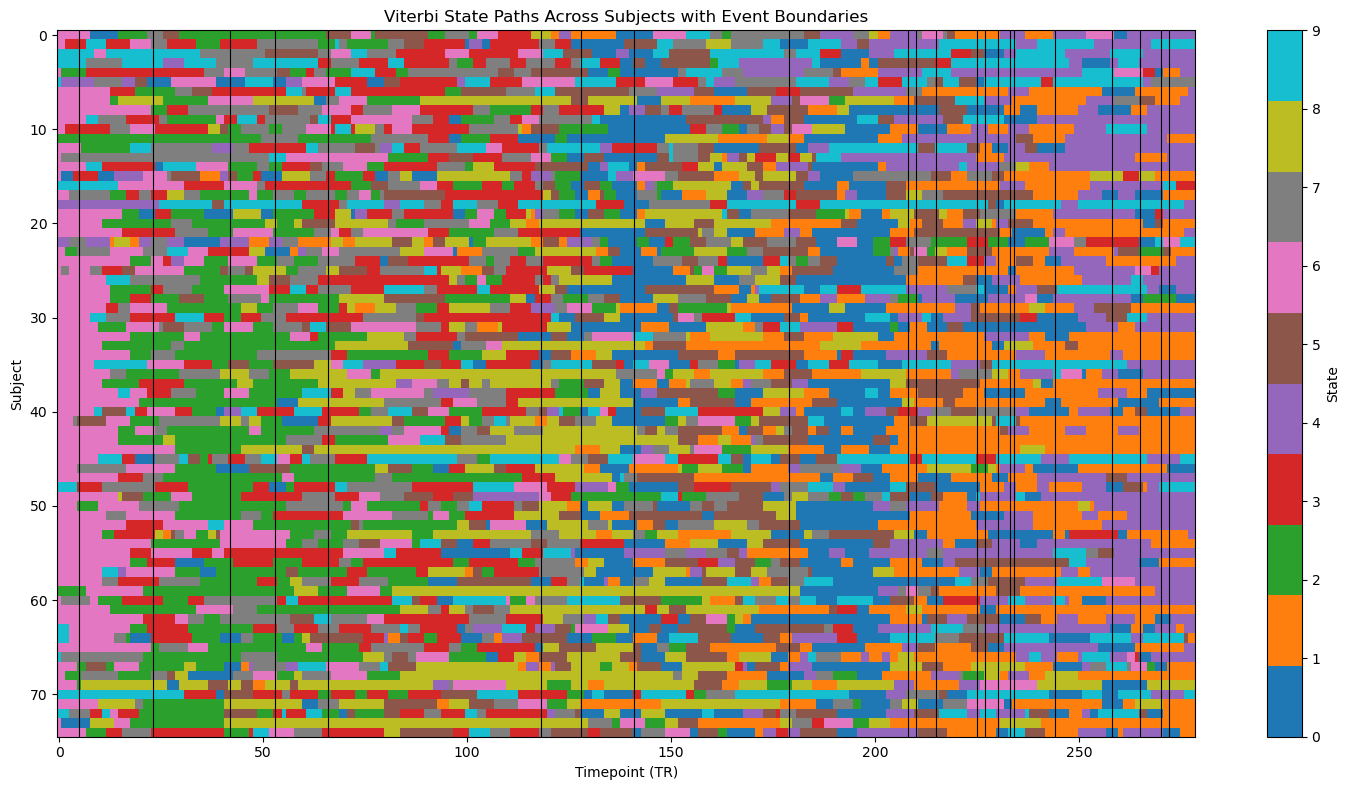

In [3]:
import matplotlib.pyplot as plt

# Convert to NumPy array for easy indexing
state_array = np.array(state_vectors)  # shape: (n_subjects, n_timepoints)
n_subjects, n_timepoints = state_array.shape

# Set up figure
plt.figure(figsize=(15, 8))

# Show image: each row is a subject, each column is a timepoint
# Use 'nearest' to avoid interpolation, and aspect='auto' to fit height
plt.imshow(state_array, aspect='auto', cmap='tab10', interpolation='nearest')

boundary_locs = [i for i, val in enumerate(event_boundaries) if val == 1]
# Overlay vertical dashed lines for event boundaries
for boundary in boundary_locs:
    boundary = int(boundary)
    plt.axvline(x=boundary, color='black', linestyle='-', linewidth=0.8)

# Labels and formatting
plt.xlabel("Timepoint (TR)")
plt.ylabel("Subject")
plt.title("Viterbi State Paths Across Subjects with Event Boundaries")
plt.colorbar(label="State")  # Optional: shows state colors
plt.tight_layout()
plt.grid(False)
plt.show()

- Within the window of each event (the event boundary TR is the first TR of the next event)
- Build some sort of null distribution and test for each window if the states within seem somewhat particularly to that event
- The null distribution should be built after circularly shifting (randomly) each subjects data and then calculating the appearance of the state in that event xN permutations 

In [4]:
# Build window boundaries: first event starts at 0 (which is TR 13 originally)
all_starts = [0] + boundary_locs
all_ends = boundary_locs + [len(event_boundaries)]

# Each pair (start, end) is a window in the trimmed event_boundaries/indexed TRs
event_windows = list(zip(all_starts, all_ends))

In [5]:
# Number of unique states (you said k=10)
n_states = 10

# Observed count matrix: shape (n_events, n_states)
observed_counts = np.zeros((len(event_windows), n_states), dtype=int)

for event_idx, (start, end) in enumerate(event_windows):
    # Get the event window from each subject
    window_data = state_array[:, start:end]
    # Flatten to get all states across all subjects in that event
    flat_states = window_data.flatten()
    # Count occurrences of each state
    for s in range(n_states):
        observed_counts[event_idx, s] = np.sum(flat_states == s)

In [6]:
n_perms = 1000
null_distributions = np.zeros((len(event_windows), n_states, n_perms), dtype=int)

rng = np.random.default_rng(42)  # for reproducibility

for p in range(n_perms):
    # Circularly shift each subject's state series
    shifted_array = np.array([
        np.roll(row, shift=rng.integers(0, n_timepoints))
        for row in state_array
    ])
    
    for event_idx, (start, end) in enumerate(event_windows):
        window_data = shifted_array[:, start:end]
        flat_states = window_data.flatten()
        for s in range(n_states):
            null_distributions[event_idx, s, p] = np.sum(flat_states == s)

In [7]:
# Compute empirical p-values (one-tailed; state is more common than expected by chance)
p_values = np.mean(null_distributions >= observed_counts[:, :, np.newaxis], axis=2)

# Optional: compute z-scores instead
null_means = null_distributions.mean(axis=2)
null_stds = null_distributions.std(axis=2)
z_scores = (observed_counts - null_means) / null_stds

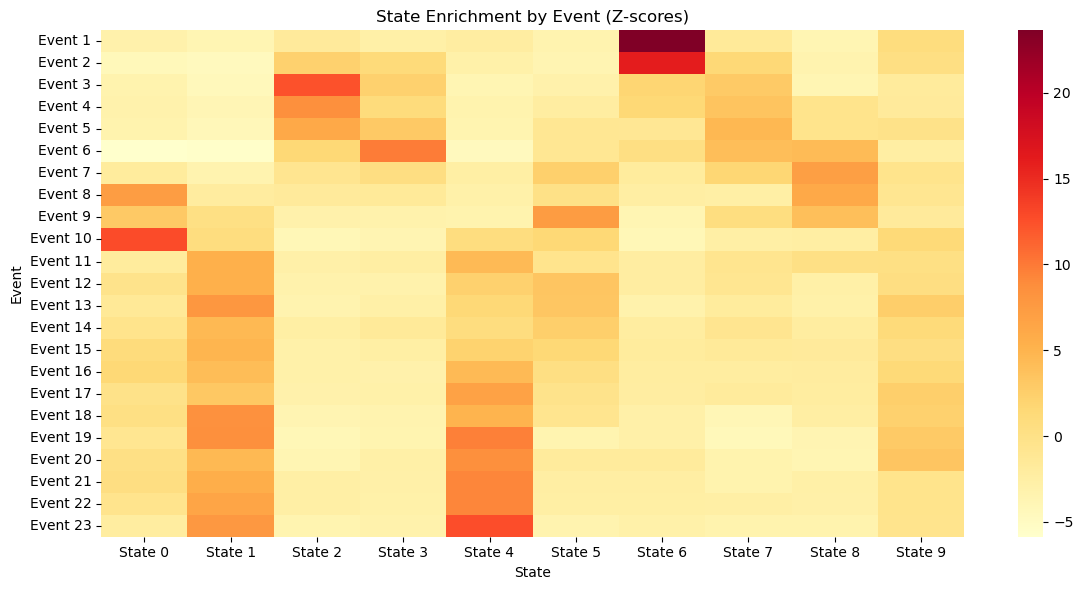

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of z-scores
plt.figure(figsize=(12, 6))
sns.heatmap(z_scores, annot=False, cmap="YlOrRd",
            xticklabels=[f"State {i}" for i in range(n_states)],
            yticklabels=[f"Event {i+1}" for i in range(len(event_windows))])
plt.title("State Enrichment by Event (Z-scores)")
plt.xlabel("State")
plt.ylabel("Event")
plt.tight_layout()
plt.show()

In [9]:
# Proportion of each state *within* each event
n_states = 10
n_events = len(event_windows)

# Rows = events, columns = states
within_event_proportions = np.zeros((n_events, n_states))

for i, (start, end) in enumerate(event_windows):
    window = state_array[:, start:end]  # subjects x TRs for event
    flattened = window.flatten()
    total_points = len(flattened)  # total subject-TRs in this event
    
    for s in range(n_states):
        within_event_proportions[i, s] = np.sum(flattened == s) / total_points 

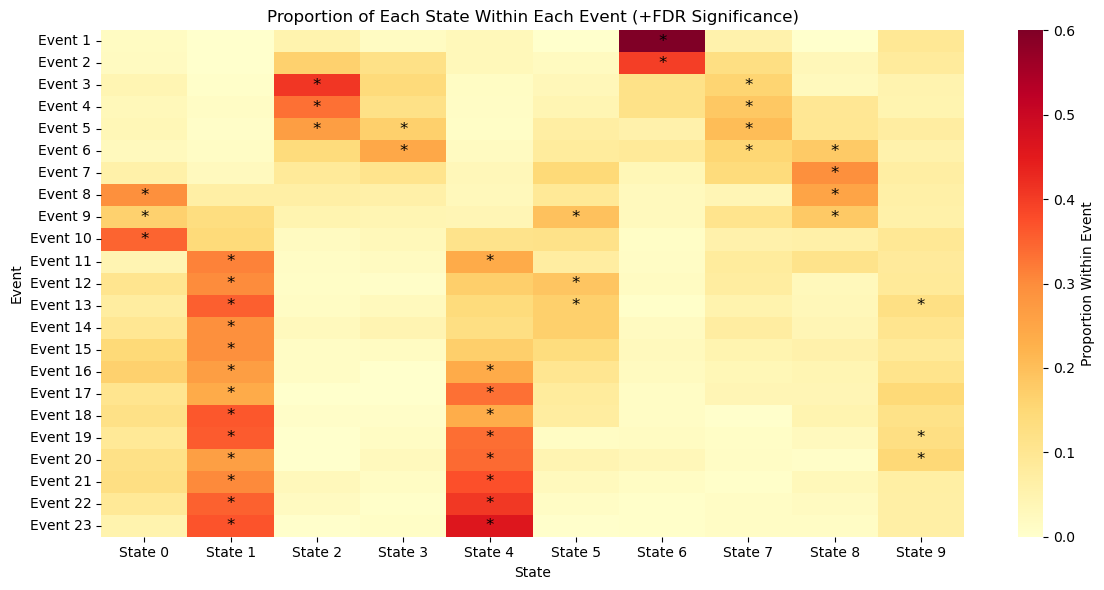

In [12]:
# Test whether that proportion differs significantly from null distribution and get p values and FDR correction for each state-event combo

n_perms = 1000
null_distributions = np.zeros((n_events, n_states, n_perms))

rng = np.random.default_rng(seed=42)

for p in range(n_perms):
    # Circularly shift each subject independently
    shifted_array = np.array([
        np.roll(row, rng.integers(n_timepoints))
        for row in state_array
    ])

    for i, (start, end) in enumerate(event_windows):
        window = shifted_array[:, start:end].flatten()
        total = len(window)
        for s in range(n_states):
            null_distributions[i, s, p] = np.sum(window == s) / total

# Shape: (n_events, n_states)
p_values = np.mean(null_distributions >= within_event_proportions[:, :, np.newaxis], axis=2)

from statsmodels.stats.multitest import multipletests

# Flatten p-values for correction
flat_p = p_values.flatten()

# Apply FDR correction
rejected, pvals_corrected, _, _ = multipletests(flat_p, alpha=0.05, method='fdr_bh')

# Reshape to original matrix
fdr_corrected_p = pvals_corrected.reshape(n_events, n_states)
significant_mask = rejected.reshape(n_events, n_states)

plt.figure(figsize=(12, 6))
sns.heatmap(
    within_event_proportions,
    cmap="YlOrRd",
    xticklabels=[f"State {s}" for s in range(n_states)],
    yticklabels=[f"Event {i+1}" for i in range(n_events)],
    cbar_kws={"label": "Proportion Within Event"},
    vmin=0, vmax=0.6
)

# Overlay significance markers
for i in range(n_events):
    for j in range(n_states):
        if significant_mask[i, j]:
            plt.text(j + 0.5, i + 0.5, '*', color='black',
                     ha='center', va='center', fontsize=12)

plt.xlabel("State")
plt.ylabel("Event")
plt.title("Proportion of Each State Within Each Event (+FDR Significance)")
plt.tight_layout()
plt.show()